Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Rb Density w/out Verdet adjustment:  6.47e+12
Rb Density w/ Verdet adjustment:  1.21e+12
Rb Density w/ Verdet adjustment:  2.43e+12
Killian Density Value:  2.96e+12


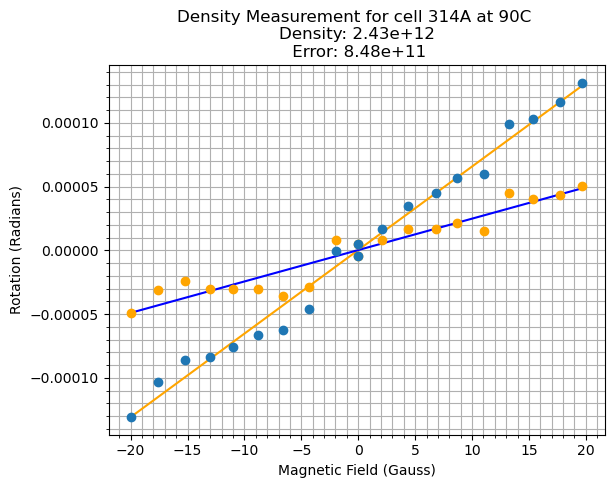

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from density_analysis.density_calculations.density_calc import rb_density, killian_density
from density_measurement.functions.utilities import formatter

#verdet_glass = (2.3e-6)*2 #radians / cm * G (this is at 773)
slope_adj = 9.61e+12
verdet_glass = 4.0870746286784294e-06 #experimentally determined


def glass_verdet_adj(rot_val, mag_field_val):
    verdet_adjment = (verdet_glass)*mag_field_val
    adjusted_rot = rot_val-verdet_adjment
    return adjusted_rot


# Get density data from csv file
fp_processed = "Data/Density/2024-08-12/2024-08-12_cell-314A_temp-90_trial-3_processed.csv"
# save into a dataframe
data_proc = pd.read_csv(fp_processed)

# Get the cell name and temperature from the file name
p = fp_processed.split('/')[-1].split('.')[0].split('_')
cell_name = p[1].split('-')[1]
temp = p[2].split('-')[1]

# Convert each column of the dataframe into a numpy array
mag_field= data_proc["Magnetic Field (Gauss)"].to_numpy()
rotation = data_proc["Rotation (Radians)"].to_numpy()
r_err_m = data_proc["Rotation Mean Absolute Error"].to_numpy()
r_err_s = data_proc["Rotation Standard Deviation"].to_numpy()

adjusted_rotation = np.zeros(len(rotation))
i = 0
for i in range(0,len(adjusted_rotation)):
    adjusted_rotation[i] = glass_verdet_adj(rotation[i], mag_field[i])


# Define a line equation for fitting
def line(x, m, b):
    return x*m+b

# Get the fit parameters
# param = [slope, intercept], param_cov = covariance matrix
param, param_cov = curve_fit(line, mag_field, rotation)
param_adj, param_cov_adj = curve_fit(line, mag_field, adjusted_rotation)

# calculate the error on the slope using param_cov
param_err = np.sqrt(param_cov_adj[0][0])
 
# Calculate the density and density error from covariance using the rb_density() function
ol = 3.7
wl = 7.80505e-05
rb_den = rb_density(param[0], ol, wl) #slope -> density
rb_den_adj = rb_density(param_adj[0], ol, wl)
rb_den_err = rb_density(param_err, ol, wl) #slope fit error -> density error

# Format density and density error from covariance matrix for display
den_fmt = formatter(rb_den, 2)
err_cov_fmt = formatter(rb_den_err, 2)

# Calculate Killian density value 
killian = killian_density(temp)

# Calculate the error using the MAE and STD DEV on each individual point
avg_err_m = 0
avg_err_s = 0
l = len(r_err_m)
for i in range(0,l):
    avg_err_m = avg_err_m + r_err_m[i]**2
    avg_err_s = avg_err_s + r_err_s[i]**2
avg_err_m = np.sqrt(avg_err_m)/l
avg_err_s = np.sqrt(avg_err_s)/l

# Convert to density units 
err_m = rb_density((avg_err_m), ol, wl)
err_s = rb_density((avg_err_s), ol, wl)

# Format error values for display
err_m_fmt = formatter(err_m, 2)
err_s_fmt = formatter(err_s, 2)

# Get minimum and maximum x values for graph
x_min = mag_field.min()
x_max = mag_field.max()

# Create line using parameters
ans = (param[0]*mag_field + param[1])
ans_1 = (param_adj[0]*mag_field + param_adj[1])

# Determine largest error value between the 3 methods
errors = np.array([param_err, avg_err_m, avg_err_s])
max_err_val = errors.max()
# Convert max error val to density units
max_err_val_den = rb_density((avg_err_s), ol, wl)
max_err_val_den_fmt = formatter(err_s, 2)
# Calculate percent error for largest error value
per_err = max_err_val_den/rb_den

# Plot magnetic field vs rotation using the fit parameters
plt.plot(mag_field, ans, '-', color ='orange')
plt.plot(mag_field, ans_1, '-', color ='blue')

plt.errorbar(mag_field, adjusted_rotation, yerr=max_err_val, fmt='o' ,color='orange')
plt.errorbar(mag_field, rotation, yerr=max_err_val, fmt="o")

# Label the axes
plt.xlabel("Magnetic Field (Gauss)")
plt.ylabel("Rotation (Radians)")

# Compare Density values
print("Rb Density w/out Verdet adjustment: ", formatter(rb_den, 2))
print("Rb Density w/ Verdet adjustment: ", formatter(rb_den-5.26e12, 2))
print("Rb Density w/ Verdet adjustment: ", formatter(rb_den_adj, 2))

print("Killian Density Value: ", formatter(killian, 2))

# Compare error values
#print("from cov: ", err_cov_fmt)
#print("from MAE: ", err_m_fmt)
#print("from STD DEV: ", err_s_fmt)
#print("Max error: ", max_err_val_den_fmt)
#print("percent error: ", np.round(per_err*100, decimals=2))


# Give the plot a title using the info in the data file
plttlt= "Density Measurement for cell "+ cell_name+ " at "+temp+"C \n"+ "Density: "+str(formatter(rb_den_adj, 2)) +"\n Error: " + str(err_s_fmt)
plt.title(plttlt)

#turn on the grid
plt.grid(which= "major")
plt.grid(which = "minor")
plt.minorticks_on()

# Display the plot
plt.show()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Verdet adjustment:  8.86e+12
from cov:  5.15e+11
from MAE:  1.35e+12
from STD DEV:  1.54e+12
Max error:  1.54e+12
percent error:  17.44
3.751220747517893e-06


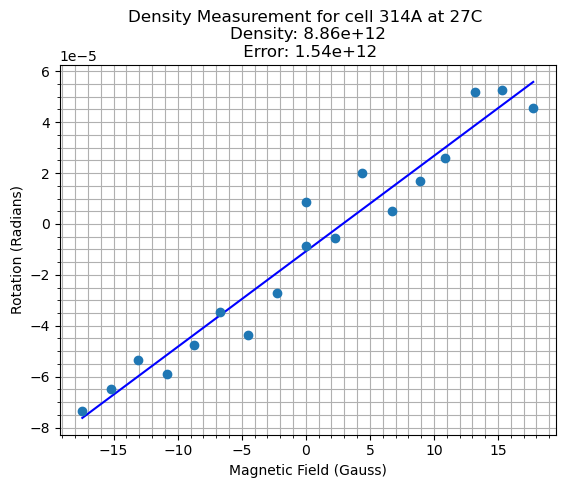

In [25]:
######### Determining the verdet constand of our cells


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from density_analysis.density_calculations.density_calc import rb_density, killian_density
from density_measurement.functions.utilities import formatter



# Get density data from csv file
fp_processed = "Data/Density/2024-08-19/2024-08-19_cell-314A_temp-27_trial-4_processed.csv"
# save into a dataframe
data_proc = pd.read_csv(fp_processed)

# Get the cell name and temperature from the file name
p = fp_processed.split('/')[-1].split('.')[0].split('_')
cell_name = p[1].split('-')[1]
temp = p[2].split('-')[1]

# Convert each column of the dataframe into a numpy array
mag_field= data_proc["Magnetic Field (Gauss)"].to_numpy()
rotation = data_proc["Rotation (Radians)"].to_numpy()
r_err_m = data_proc["Rotation Mean Absolute Error"].to_numpy()
r_err_s = data_proc["Rotation Standard Deviation"].to_numpy()

adj = []
i = 0
for i in range(0, len(rotation)):
    adj.append(glass_verdet_adj(rotation[i], mag_field[i]))

# Define a line equation for fitting
def line(x, m, b):
    return x*m+b

# Get the fit parameters
# param = [slope, intercept], param_cov = covariance matrix
param, param_cov = curve_fit(line, mag_field, rotation)#rotation)

# calculate the error on the slope using param_cov
param_err = np.sqrt(param_cov[0][0])
 
# Calculate the density and density error from covariance using the rb_density() function
ol = 3.7
wl = 7.8065e-05
rb_den = rb_density(param[0], ol, wl)
rb_den_err = rb_density(param_err, ol, wl) #slope fit error -> density error

# Format density and density error from covariance matrix for display
den_fmt = formatter(rb_den, 2)
err_cov_fmt = formatter(rb_den_err, 2)

# Calculate the error using the MAE and STD DEV on each individual point
avg_err_m = 0
avg_err_s = 0
l = len(r_err_m)
for i in range(0,l):
    avg_err_m = avg_err_m + r_err_m[i]**2
    avg_err_s = avg_err_s + r_err_s[i]**2
avg_err_m = np.sqrt(avg_err_m)/l
avg_err_s = np.sqrt(avg_err_s)/l

# Convert to density units 
err_m = rb_density((avg_err_m), ol, wl)
err_s = rb_density((avg_err_s), ol, wl)

# Format error values for display
err_m_fmt = formatter(err_m, 2)
err_s_fmt = formatter(err_s, 2)

# Get minimum and maximum x values for graph
x_min = mag_field.min()
x_max = mag_field.max()

# Create line using parameters
ans = (param[0]*mag_field + param[1])

# Determine largest error value between the 3 methods
errors = np.array([param_err, avg_err_m, avg_err_s])
max_err_val = errors.max()
# Convert max error val to density units
max_err_val_den = rb_density((avg_err_s), ol, wl)
max_err_val_den_fmt = formatter(err_s, 2)
# Calculate percent error for largest error value
per_err = max_err_val_den/rb_den

# Plot magnetic field vs rotation using the fit parameters
plt.plot(mag_field, ans, '-', color ='blue')

#plt.errorbar(mag_field, adjusted_rotation, yerr=max_err_val, fmt='o' ,color='orange')
plt.errorbar(mag_field, rotation, yerr=max_err_val, fmt="o")

# Label the axes
plt.xlabel("Magnetic Field (Gauss)")
plt.ylabel("Rotation (Radians)")

# Compare Density values
print("Verdet adjustment: ", formatter(rb_den, 2))


# Compare error values
print("from cov: ", err_cov_fmt)
print("from MAE: ", err_m_fmt)
print("from STD DEV: ", err_s_fmt)
print("Max error: ", max_err_val_den_fmt)
print("percent error: ", np.round(per_err*100, decimals=2))
print(param[0])


# Give the plot a title using the info in the data file
plttlt= "Density Measurement for cell "+ cell_name+ " at "+temp+"C \n"+ "Density: "+str(formatter(rb_den, 2)) +"\n Error: " + str(err_s_fmt)
plt.title(plttlt)

#turn on the grid
plt.grid(which= "major")
plt.grid(which = "minor")
plt.minorticks_on()

# Display the plot
plt.show()
